# Setup

## Imports

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt
from google.colab import drive
import time

## Conexão com o Drive

In [ ]:
drive.mount('/content/drive')

## Conferência da existência de uma GPU

É preciso a GPU para fazer o teste de performance do código com GPU e com CPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Processamento das imagens e separação entre dados de teste e treino

## Funções de vetorização das imagens e labels

In [ ]:
def vetorizar_imagens_talhao(caminho):
    lista_imagens = []
    labels = []
    for pasta_imagem_grande in os.listdir(caminho):
        caminho_pasta_imagem_grande = os.path.join(caminho, pasta_imagem_grande)
        for pasta_imagem_cortada in os.listdir(caminho_pasta_imagem_grande):
            caminho_pasta_imagem_cortada = os.path.join(caminho_pasta_imagem_grande, pasta_imagem_cortada)
            caminho_imagem = os.path.join(caminho_pasta_imagem_cortada, os.listdir(caminho_pasta_imagem_cortada)[1])
            img = cv2.imread(caminho_imagem)
            lista_imagens.append(img)
            labels.append(1)

    random.shuffle(lista_imagens)

    lista_imagens = lista_imagens[:200]
    labels = labels[:200]

    return np.array(lista_imagens), np.array(labels)

def vetorizar_imagem_desmatamento(caminho_desmatamento):
    lista_imagens = []
    labels = []
    for nome_imagem in os.listdir(caminho_desmatamento):
        caminho_imagem = os.path.join(caminho_desmatamento, nome_imagem)
        img = cv2.imread(caminho_imagem)
        lista_imagens.append(img)
        labels.append(0)
    return np.array(lista_imagens), np.array(labels)

## Vetorização das imagens dos talhões

In [ ]:
with tf.device('/gpu:0'):
    caminho = '/content/drive/MyDrive/cropped_images'
    imagens_numpy, labels_numpy = vetorizar_imagens_talhao(caminho)

    print(imagens_numpy.shape)

## Vetorização das imagens de desmatamento

In [ ]:
with tf.device('/gpu:0'):
    caminho_desmatamento = '/content/drive/MyDrive/cropped_desmatamento'
    imagens_desmatamento, labels_desmatamento = vetorizar_imagem_desmatamento(caminho_desmatamento)

    print(imagens_desmatamento.shape)

## Combinação e normalização das imagens

In [ ]:
with tf.device('/gpu:0'):
    combined_images = np.concatenate((imagens_numpy, imagens_desmatamento), axis=0)
    combined_labels = np.concatenate((labels_numpy, labels_desmatamento), axis=0)

    combined_images = combined_images / 255.0

    print("Shape of the combined array:", combined_images.shape)

## Separação entre dados de teste e treino

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
(trainX, testX, trainY, testY) = train_test_split(combined_images, combined_labels)
trainY = to_categorical(trainY, 2)
testY = to_categorical(testY, 2)

# Modelo

## Arquitetura do modelo

Para o desenvolvimento do nosso modelo, adotamos duas principais referências: a arquitetura LeNet, inicialmente apresentada por Yann LeCun e seus colegas no artigo "Gradient-Based Learning Applied to Document Recognition" [1], e as diretrizes fornecidas em aula pelo Prof. Raphael durante nossas instruções.

Nos inspiramos inicialmente na estrutura LeNet, especialmente nas duas primeiras camadas de convolução, onde mantivemos a mesma quantidade de neurônios, porém optamos por reduzir o tamanho do kernel para aumentar a precisão na detecção de bordas dos talhões de imagens.

Além disso, seguindo as recomendações do Prof. Raphael durante a aula, decidimos incrementar o número de camadas de nossa rede com o objetivo facilitar a extração de características mais complexas das imagens, adaptando o modelo às necessidades específicas de nosso projeto.

Em relação ao notebook usado na aula, nosso modelo preserva o mesmo número de camadas e operações de pooling, mas altera o número de neurônios e o tamanho das janelas de pooling para reduzir a quantidade de parâmetros treináveis, otimizando o desempenho computacional do modelo sem comprometer sua eficácia.

[1] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(200*200*3, activation='relu'),  # Número de unidades igual ao tamanho da imagem de saída
    # tf.keras.layers.Reshape((200, 200, 3)),  # Redimensionar para o formato da imagem de saída
    # tf.keras.layers.Activation('sigmoid')    # Ativação para valores de pixel entre 0 e 1
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()


## Métricas, função de perda e otimizador do modelo

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Treinamento do modelo

In [ ]:
with tf.device('/gpu:0'):
    H = model.fit(trainX, trainY, batch_size=64, epochs=20, verbose=2,
            validation_data=(testX, testY))

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Precisão do conjunto de Treino')
plt.plot(epochs, val_acc, 'b', label='Precisão do conjunto de Validação')
plt.title('Precisão dos conjuntos de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend(loc=0)
plt.figure()

plt.show()

## Teste do modelo

In [ ]:
predictions = model.predict(testX, batch_size=8, verbose=2)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1),
                              target_names=[str(label) for label in range(2)]))

## Teste entre GPU e CPU

### Função para teste de processamento

In [ ]:
def train_and_infer(model, device, trainX, trainY, testX, testY):
    with tf.device(device):
        start_time = time.time()
        history = model.fit(trainX, trainY, batch_size=64, epochs=20, verbose=2,
                            validation_data=(testX, testY))
        elapsed_time = time.time() - start_time
        return elapsed_time

### Realizando o teste

In [ ]:
# Treinamento em GPU
gpu_time = train_and_infer(model, '/gpu:0', trainX, trainY, testX, testY)

# Treinamento em CPU
cpu_time = train_and_infer(model, '/cpu:0', trainX, trainY, testX, testY)


best_choice = 'GPU' if gpu_time < cpu_time else 'CPU'

print(
  f"Tempo de treinamento de GPU: {gpu_time:.2f} seconds, "
  f"Tempo de treinamento de CPU: {cpu_time:.2f} seconds, "
  f"Melhor escolha: {best_choice}"
)

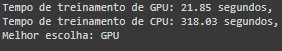

# Transfer Learning

## Modelos

### Inception v3 Model


O Inception-v3, apresentado no artigo "Rethinking the Inception Architecture for Computer Vision" [1], é uma arquitetura de rede neural convolucional (CNN) projetada com foco na eficiência computacional e no alto desempenho. Desenvolvido com base em uma reavaliação profunda da arquitetura Inception, o modelo introduz várias inovações para melhorar a capacidade de reconhecimento de imagens.

Uma das características principais do Inception-v3 são os módulos Inception, que consistem em blocos de construção flexíveis compostos por várias camadas de convolução paralelas de diferentes tamanhos de filtro. Esses módulos são projetados para capturar informações em várias escalas e resoluções, permitindo que o modelo aprenda representações mais ricas e complexas das imagens, como discutido no artigo.

O modelo alcançou resultados impressionantes em várias métricas de avaliação. Por exemplo, o Inception-v3 alcançou uma taxa de erro de 21.2% para o top-1 e 5.6% para o top-5 na avaliação de uma única imagem no conjunto de dados de classificação ILSVRC 2012. Esses resultados representam uma redução significativa em relação aos modelos anteriores, como o AlexNet, que obteve uma taxa de erro de aproximadamente 15.3% para o top-5 na mesma avaliação.


**Referências:**

[1] Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, Zbigniew Wojna, "Rethinking the Inception Architecture for Computer Vision", 2015. https://arxiv.org/abs/1512.00567


In [ ]:
inception_weights = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
if not os.path.exists(inception_weights):
    !wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
        -O {inception_weights}

### Resnet

A ResNet, ou Rede Residual, foi introduzida no artigo "Deep Residual Learning for Image Recognition" [1] e é uma CNN projetada para combater os desafios do treinamento de redes neurais profundas. Seu objetivo era superar a diminuição de desempenho causada pelo problema do gradiente vanishing (desaparecimento do gradiente) ao mesmo tempo em que permitia a construção de redes com centenas de camadas.

A inovação central da ResNet é o bloco residual. Esse bloco consiste em caminhos paralelos que realizam operações de convolução, mas com a adição de conexões de atalho (skip connections). Essas conexões permitem que os gradientes sejam propagados diretamente, resultando em uma rede mais fácil de treinar e evitando a degradação da performance.

No desafio de classificação de imagem ILSVRC 2015 ele alcançou uma taxa de erro top-5 de 3.57% e além disso a arquitetura mostrou-se adaptável e foi utilizada como base para outras arquiteturas mais avançadas, provando sua relevância e flexibilidade no campo da visão computacional.

**Referências**

[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition.

In [ ]:
resnet_weights = '/tmp/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
if not os.path.exists(resnet_weights):
    !wget --no-check-certificate \
        https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 \
        -O {resnet_weights}

### EfficientNet


A EfficientNet, introduzida no artigo "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks" [1], é uma CNN feita para otimizar o tradeoff entre precisão e eficiência computacional, introduzindo o método de escalonamento composto para realizar isto.

O conceito por trás da EfficientNet é que simplesmente aumentar a profundidade ou a largura da rede nem sempre resulta em melhorias de desempenho, logo o escalonamento composto permite que a rede seja adaptada igualitariamente, ajustando as três dimensões de forma balanceada com base em um coeficiente fixo. Visando utilizar os recursos computacionais de forma mais eficiente e permitindo um melhor desempenho sem aumentar excessivamente os requisitos computacionais.

A rede demonstrou uma eficácia notável em benchmarks como o ImageNet, alcançando uma taxa de erro top-1 de apenas 15.8% e top-5 de 4.5%, enquanto utilizava significativamente menos parâmetros e FLOPS (operações de ponto flutuante por segundo) em comparação com outras arquiteturas.

[1] Tan, M., & Le, Q. V. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. In Proceedings of the International Conference on Machine Learning (ICML).

## Arquitetura dos Modelos

### Imports necessários

In [ ]:
import os
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.applications import InceptionV3, EfficientNetB0, ResNet50

### Carregar os pesos

In [ ]:
def load_weights(model_name):
    if model_name == 'inception':
        weights_file = inception_weights
    elif model_name == 'resnet50':
        weights_file = resnet_weights
    else:
        weights_file = None
    return weights_file

### Criar modelo pré-treinado

In [ ]:
# Definindo a função para criar o modelo pré-treinado
def create_pre_trained_model(model_name='inception'):
    if model_name == 'inception':
        weights_file = load_weights(model_name)
        pre_trained_model = InceptionV3(input_shape=(200, 200, 3), include_top=False, weights=None)
        pre_trained_model.load_weights(weights_file)
        last_layer_name = 'mixed2'
    elif model_name == 'efficientnetb0':
        pre_trained_model = EfficientNetB0(input_shape=(200, 200, 3), include_top=False, weights='imagenet')
        last_layer_name = 'block7a_project_bn'
    elif model_name == 'resnet50':
        weights_file = load_weights(model_name)
        pre_trained_model = ResNet50(input_shape=(200, 200, 3), include_top=False, weights=None)
        pre_trained_model.load_weights(weights_file)
        last_layer_name = 'conv4_block6_out'
    else:
        raise ValueError("Model name should be 'inception', 'efficientnetb0', or 'resnet50'")

    # Congelando os pesos do modelo pré-treinado
    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model, last_layer_name

In [ ]:
# Criando o modelo pré-treinado (por padrão, será utilizado o modelo Inception) e exibindo um resumo
pre_trained_model, last_layer_name = create_pre_trained_model()
pre_trained_model.summary()

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"Total de parâmetros no modelo é de {total_params:,}.")
print(f"Total de parâmetros que podem ser treinados no modelo são {num_trainable_params:,}.")

In [ ]:
# Definindo a função para obter a saída da última camada do modelo pré-treinado (por padrão, será utilizado a camada do modelo Inception)
def output_of_last_layer(pre_trained_model, last_layer_name='mixed2'):
    last_desired_layer = pre_trained_model.get_layer(last_layer_name)
    print('dimensão da última camada selecionada: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('dimensão da camada do modelo: ', last_output)
    return last_output

In [ ]:
# Obtendo a saída da última camada do modelo pré-treinado
last_output = output_of_last_layer(pre_trained_model)

In [ ]:
# Definindo a função para criar o modelo final
def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)
  x = layers.Dense(32, activation='relu')(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Dense  (2, activation='softmax')(x)

  # Criando o modelo final
  model = Model(pre_trained_model.input, x)
  model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
model = create_final_model(pre_trained_model, last_output)

total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"Total de parâmetros no modelo é de {total_params:,}.")
print(f"Total de parâmetros que podem ser treinados no modelo são {num_trainable_params:,}.")

In [ ]:
# Criando o modelo final
model = create_final_model(pre_trained_model, last_output)
model.summary()

In [ ]:
# Treinando o modelo
H = model.fit(trainX, trainY, batch_size=64, epochs=20, verbose=2,
            validation_data=(testX, testY))

In [ ]:
# Extraindo métricas de treinamento
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

# Plotando as métricas de treinamento
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Precisão do conjunto de Treino')
plt.plot(epochs, val_acc, 'b', label='Precisão do conjunto de Validação')
plt.title('Precisão dos conjuntos de Treino e Validação InceptionV3')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend(loc=0)
plt.figure()

plt.show()

## Comparação de Modelos

### Treinar todos os modelos e salvar suas métricas

In [ ]:
# Nome dos modelos disponíveis
model_names = ['inception', 'efficientnetb0', 'resnet50']

# Dicionário de resultados
training_histories = {}

# Iterar todos os modelos disponíveis e salvar seus resultados
for model_name in model_names:
    pre_trained_model, last_layer_name = create_pre_trained_model(model_name)
    last_output = output_of_last_layer(pre_trained_model, last_layer_name)
    model = create_final_model(pre_trained_model, last_output)
    print(f'{model_name}: modelo criado')

    history = model.fit(trainX, trainY, batch_size=64, epochs=20, verbose=2,
                        validation_data=(testX, testY))
    training_histories[model_name] = history
    print(f'{model_name}: métricas salvas com sucesso.')


### Comparação de acurácia

In [ ]:
# Inicializar os gráficos lado-a-lado para facilitar comparação
fig, axs = plt.subplots(1, len(training_histories), figsize=(18, 6))

# Iterar os dados para criar os gráficos
for idx, (model_name, history) in enumerate(training_histories.items()):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    axs[idx].plot(epochs, acc, 'r', label='Precisão do conjunto de Treino')
    axs[idx].plot(epochs, val_acc, 'b', label='Precisão do conjunto de Validação')
    axs[idx].set_title(f'Precisão dos conjuntos de Treino e Validação de "{model_name}"')
    axs[idx].set_xlabel('Épocas')
    axs[idx].set_ylabel('Precisão')
    axs[idx].grid(True)

plt.tight_layout()
plt.show()


### Discussão e escolha de modelo definitivo

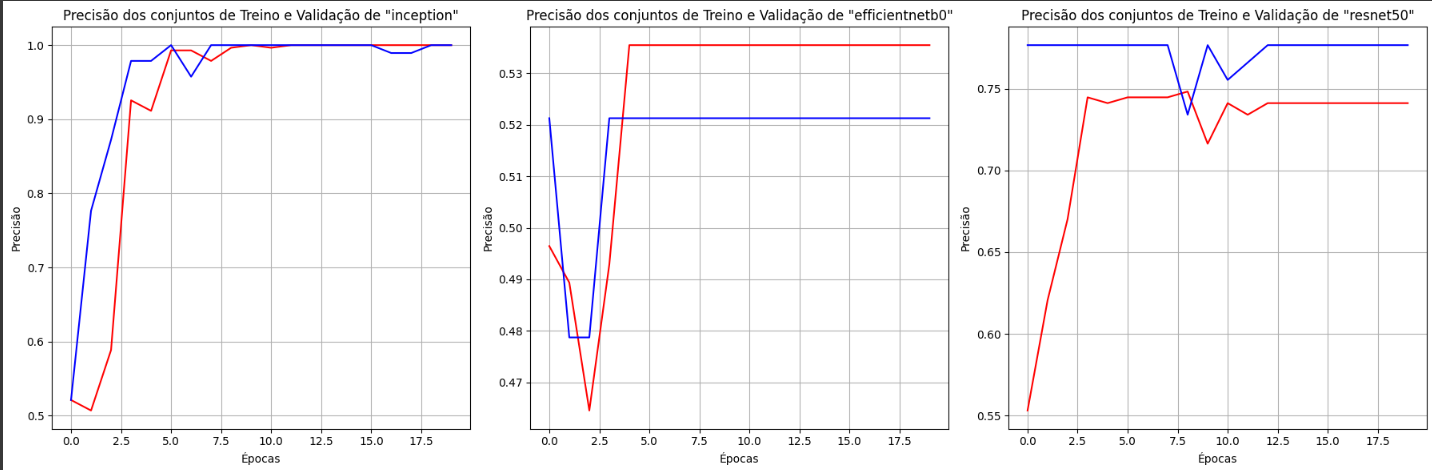


Analisando os resultados, é possível afirmar que o melhor modelo é o Inception V3

No gráfico da Inception V3 é possível notar um aumento acelerado na precisão nos estágios iniciais, que estabiliza acima dos 90%. Este comportamento indica uma convergência eficiente, sugerindo que a rede tem habilidade para assimilar características complexas dos dados sem sofrer de sobreajuste. A proximidade entre as curvas de treino e validação reforça sua capacidade de generalização robusta.

Analisando os outros modelos, vemos que a EfficientNetB0 apresenta a mais baixa precisão, levemente ultrapassando 52%, e mesmo que a ResNet50 mostre uma estabilidade superior á essa, ela ainda oscila em torno de 75% de precisão, não alcançando os patamares observados no Inception V3.

Logo, podemos afirmar que o melhor modelo pré-treinado para nossos dados é o Inception V3

## Teste entre GPU e CPU

### Realizando o teste

In [ ]:
performance_results = {}

# Testando todos os modelos tanto em CPU quanto em GPU
for model_name in model_names:
    print(f"Testando {model_name}")
    pre_trained_model, last_layer_name = create_pre_trained_model(model_name)
    last_output = output_of_last_layer(pre_trained_model, last_layer_name)
    model = create_final_model(pre_trained_model, last_output)

    # Treinamento em GPU
    gpu_time = train_and_infer(model, '/gpu:0', trainX, trainY, testX, testY)
    # Treinamento em CPU
    cpu_time = train_and_infer(model, '/cpu:0', trainX, trainY, testX, testY)

    # Salvar resultados
    performance_results[model_name] = {
        'gpu_time': gpu_time,
        'cpu_time': cpu_time
    }

In [ ]:
# Comparar resultados e devolver a melhor escolha para o treinamento.
for model_name, times in performance_results.items():
    gpu_time = times['gpu_time']
    cpu_time = times['cpu_time']
    best_choice = 'GPU' if gpu_time < cpu_time else 'CPU'

    print(
        f"{model_name.capitalize()}: "
        f"Tempo de treinamento de GPU: {gpu_time:.2f} seconds, "
        f"Tempo de treinamento de CPU: {cpu_time:.2f} seconds, "
        f"Melhor escolha: {best_choice}"
    )

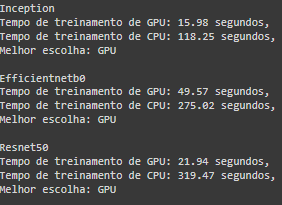